Extraction And Exploration
--------------------

In this section, we will analyse the data that we are using for the problem. We will download the data first and extract it into usable form. We will also look into features and characteristics of the dataset.
The methods are based on the Udacity Deep Learning Course.


In [37]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import tensorflow as tf
import json
import random
import string
import h5py
import matplotlib
from collections import Counter

#Global Variables


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

The following functions are for downloading the dataset


In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print('Failed to verify ' + filename + '. Please delete and try again')
  return filename

In [4]:
maybe_download('train.tar.gz', 423624704) #SVHN Format 1
maybe_download('test.tar.gz', 276555967) #SVHN Format 1
# maybe_download('extra.tar.gz', 2055208) #SVHN Format 1, downloaded separately
maybe_download('train_32x32.mat', 0) #SVHN Format 2
maybe_download('test_32x32.mat', 0) #SVHN Format 2
maybe_download('extra_32x32.mat', 0) #SVHN Format 2

Failed to verify train.tar.gz. Please delete and try again
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified test.tar.gz
Attempting to download: train_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Failed to verify train_32x32.mat. Please delete and try again
Attempting to download: test_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Failed to verify test_32x32.mat. Please delete and try again
Attempting to download: extra_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Dow

'extra_32x32.mat'

Now extracting the dataset

In [39]:
num_classes = 10
np.random.seed(133)
train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
extra_filename = 'extra.tar.gz'

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  if not os.path.exists(root+'/digitStruct.mat'):
    print("digitStruct.mat is missing")
  return root+'/digitStruct.mat'
  
train_struct = maybe_extract(train_filename)
test_struct = maybe_extract(test_filename)
extra_struct = maybe_extract(extra_filename)

# print(train_struct)
# print(test_struct)
# print(extra_struct)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.
Extracting data for extra. This may take a while. Please wait.


Now checking some random images to ensure that the data is extracted properly

test/85.png


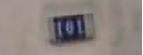

test/63.png


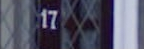

test/61.png


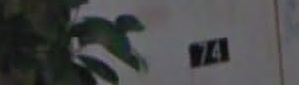

test/27.png


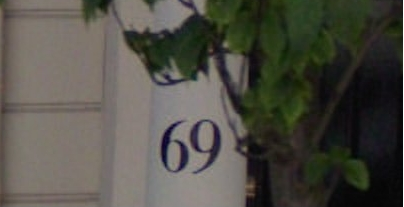

test/50.png


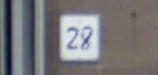

test/58.png


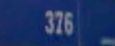

test/44.png


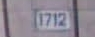

test/34.png


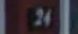

test/28.png


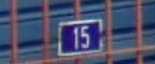

test/2.png


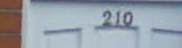

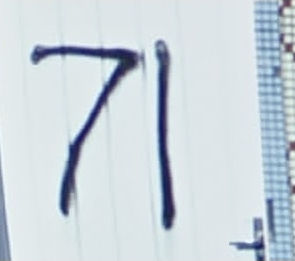

In [40]:
for i in range(1,11):
    i = random.randint(0,99)
    i = str(i)
    print("test/%s.png" %i)
    display(Image("test/%s.png" %i))
display(Image("extra/%s.png" %i))

Now let's load the data in a more manageable format. Since, depending on the computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.
We'll convert the entire dataset into an array of floating point values.

In [31]:
pixel_depth = 255.0  # Number of levels per pixel.
screen_width = 800
screen_height = 600

def get_attr(c, i, attr):
    d = c[c['digitStruct']['bbox'][i][0]][attr].value.squeeze()
    if d.dtype == 'float64':
        return d.reshape(-1)
    return np.array([c[x].value for x in d]).squeeze()

def get_label(c, i):
    d = c[c['digitStruct']['name'][i][0]].value.tostring()
    return d.replace('\x00', '')

def load_data(path):
    c = h5py.File(path)
    images = a = np.ndarray(shape=(c['digitStruct']['name'].shape[0], ), dtype='|S15')
    labels = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    labels.fill(10)
    tops = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    heights = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    widths = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    lefts = np.zeros((len(c['digitStruct']['bbox']), 6), dtype=float)
    for i in xrange(c['digitStruct']['name'].shape[0]):
        images[i] = get_label(c, i)
        l = get_attr(c, i, 'label')
        t = get_attr(c, i, 'top')
        h = get_attr(c, i, 'height')
        w = get_attr(c, i, 'width')
        le = get_attr(c, i, 'left')
        
        labels[i, :l.shape[0]] = l
        tops[i, :t.shape[0]] = t
        heights[i, :h.shape[0]] = h
        widths[i, :w.shape[0]] = w
        lefts[i, :le.shape[0]] = le
    
        if (i % 5000 == 0):
            print(i, "elapsed")
    
    return labels, images, tops, heights, widths, lefts

In [41]:
train__tuple = load_data('train/digitStruct.mat')
test__tuple = load_data('test/digitStruct.mat')
extra__tuple = load_data('extra/digitStruct.mat')

0 elapsed
5000 elapsed
10000 elapsed
15000 elapsed
20000 elapsed
25000 elapsed
30000 elapsed
0 elapsed
5000 elapsed
10000 elapsed
0 elapsed
5000 elapsed
10000 elapsed
15000 elapsed
20000 elapsed
25000 elapsed
30000 elapsed
35000 elapsed
40000 elapsed
45000 elapsed
50000 elapsed
55000 elapsed
60000 elapsed
65000 elapsed
70000 elapsed
75000 elapsed
80000 elapsed
85000 elapsed
90000 elapsed
95000 elapsed
100000 elapsed
105000 elapsed
110000 elapsed
115000 elapsed
120000 elapsed
125000 elapsed
130000 elapsed
135000 elapsed
140000 elapsed
145000 elapsed
150000 elapsed
155000 elapsed
160000 elapsed
165000 elapsed
170000 elapsed
175000 elapsed
180000 elapsed
185000 elapsed
190000 elapsed
195000 elapsed
200000 elapsed


In [107]:
 def maybe_pickle(struct, force=False):
    if os.path.exists(struct + '.pickle') and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % struct)
    else:
      print('Pickling %s.' % struct + '.pickle')
      permutation = np.random.permutation(extra__tuple[1].shape[0])[:2000]
      dataset = {
            'train': {
                'labels': train__tuple[0],
                'images': train__tuple[1],  
                'tops': train__tuple[2],
                'heights': train__tuple[3],
                'widths': train__tuple[4],
                'lefts': train__tuple[5],
                
                
            }, 
            'test': {
                'labels': test__tuple[0],
                'images': test__tuple[1],  
                'tops': test__tuple[2],
                'heights': test__tuple[3],
                'widths': test__tuple[4],
                'lefts': test__tuple[5],
            },
            'extra': {
                'labels': extra__tuple[0],
                'images': extra__tuple[1],  
                'tops': extra__tuple[2],
                'heights': extra__tuple[3],
                'widths': extra__tuple[4],
                'lefts': extra__tuple[5],
            },
            'valid': {
                'labels': extra__tuple[0][permutation],
                'images': extra__tuple[1][permutation],  
                'tops': extra__tuple[2][permutation],
                'heights': extra__tuple[3][permutation],
                'widths': extra__tuple[4][permutation],
                'lefts': extra__tuple[5][permutation],
            }
      }
      try:
        with open( struct + '.pickle', 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to',  struct + '.pickle', ':', e)
  
    return  struct + '.pickle'

In [108]:
extra__tuple[0][[1,2,3,4]].shape
maybe_pickle('svhn')
with open('svhn.pickle', 'rb') as f:
        dataset = pickle.load(f)

svhn already present - Skipping pickling.


[  1.   4.   5.  10.  10.  10.]
[ 30.  30.  26.   0.   0.   0.]
[ 22.  22.  22.   0.   0.   0.]
[ 12.  11.  12.   0.   0.   0.]
[ 61.  74.  85.   0.   0.   0.]
()
12346.png


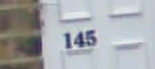

In [132]:
i = 12345
print(dataset["test"]['labels'][i])
print(dataset["test"]['tops'][i])
print(dataset["test"]['heights'][i])
print(dataset["test"]['widths'][i])
print(dataset["test"]['lefts'][i])
print(dataset["test"]['images'][i].shape)
image_str = (dataset["test"]['images'][i])
print(image_str)
display(Image("test/%s" %image_str))

Finding out mean, median and standard deviation on these features on train and test dataset

In [119]:
np.mean(np.max(dataset["train"]["tops"], axis=1)), np.median(np.max(dataset["train"]["tops"], axis=1)), \
np.std(np.max(dataset["train"]["tops"], axis=1))

(12.419885036824143, 8.0, 14.617703930449126)

In [120]:
np.mean(np.max(dataset["train"]["heights"], axis=1)), np.median(np.max(dataset["train"]["heights"], axis=1)), \
np.std(np.max(dataset["train"]["heights"], axis=1))

(34.366175678103104, 30.0, 19.378433640423562)

In [121]:
np.mean(np.max(dataset["train"]["widths"], axis=1)), np.median(np.max(dataset["train"]["widths"], axis=1)), \
np.std(np.max(dataset["train"]["widths"], axis=1))

(18.660349679659902, 16.0, 11.759940469313531)

In [122]:
np.mean(np.max(dataset["train"]["lefts"], axis=1)), np.median(np.max(dataset["train"]["lefts"], axis=1)), \
np.std(np.max(dataset["train"]["lefts"], axis=1))

(64.845697862403455, 51.0, 43.872848079402964)

In [123]:
np.mean(np.max(dataset["test"]["tops"], axis=1)), np.median(np.max(dataset["test"]["tops"], axis=1)), \
np.std(np.max(dataset["test"]["tops"], axis=1))

(23.456075910621365, 14.0, 27.288376244873561)

In [124]:
np.mean(np.max(dataset["test"]["heights"], axis=1)), np.median(np.max(dataset["test"]["heights"], axis=1)), \
np.std(np.max(dataset["test"]["heights"], axis=1))

(27.898607284970922, 24.0, 13.45875541177187)

In [125]:
np.mean(np.max(dataset["test"]["widths"], axis=1)), np.median(np.max(dataset["test"]["widths"], axis=1)), \
np.std(np.max(dataset["test"]["widths"], axis=1))

(17.250688705234161, 15.0, 8.7802855727145062)

In [126]:
np.mean(np.max(dataset["test"]["lefts"], axis=1)), np.median(np.max(dataset["test"]["lefts"], axis=1)), \
np.std(np.max(dataset["test"]["lefts"], axis=1))

(85.914600550964181, 64.0, 64.627596694688322)

Plotting some graphs for visualisation

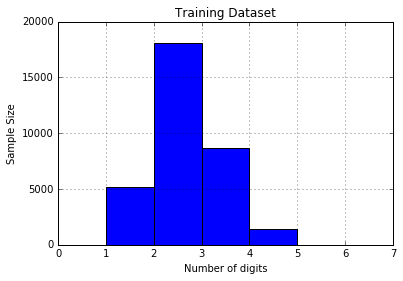

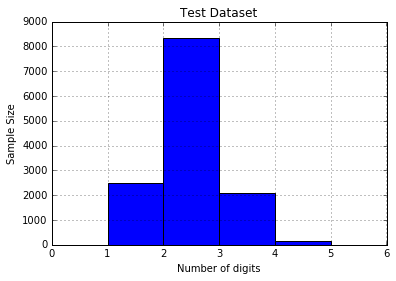

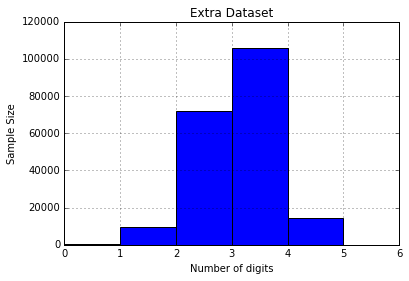

In [131]:
count = Counter(np.sum(dataset["train"]["tops"] > 0, axis =1))
l = plt.bar(count.keys(), count.values(), 1, color="blue")

plt.xlabel('Number of digits')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Training Dataset')

plt.show()

count = Counter(np.sum(dataset["test"]["tops"] > 0, axis =1))
l = plt.bar(count.keys(), count.values(), 1, color="blue")

plt.xlabel('Number of digits')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Test Dataset')

plt.show()

count = Counter(np.sum(dataset["extra"]["tops"] > 0, axis =1))
l = plt.bar(count.keys(), count.values(), 1, color="blue")

plt.xlabel('Number of digits')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Extra Dataset')

plt.show()